<a href="https://colab.research.google.com/github/vitorquintella/personal-ml-study/blob/main/Exerc%C3%ADcio_Rede_Neural_Tradicional_Paisagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resumo:

* Fazer uma rede neural para o exemplo de classificação de paisagens

1. Quantas camadas foram utilizadas? Houve alteração de desempenho aumentando ou diminuindo a quantidade de camadas?
  * **Resposta**:  O melhor modelo apresentou 3 camadas, menos camadas deixaram o desempenho mais instavel, e mais camadas não agregaram mais acurácia.

2. Quantos neurônios em cada camada? Houve alteração de desempenho aumentando ou diminuindo a quantidade de camadas?
  * **Resposta**:  O melhor modelo apresentou um crescente de 105,126 e 168 neuronios, menos menos neuronios não conseguiram aprender e mais neuronios não agregaram mais valor.

3. Foi necessário utilizar técnicas de regularização?
  * **Resposta**:  Sim. Houver tendência de oversampling. Não consegui melhorar o modelo com o dropout. Parei o modelo precocemente para evitar o overfit.

4. Qual a avaliação do modelo? Houve overfiting?
  * **Resposta**:  No modelo utilizado, com para precoce não houve overfitting significativo.

5. Realize a leitura da base de teste e aplique o mesmo pré-processamento do treinamento (base seq_test). Houve alteração no desempenho na base de teste?
  * **Resposta**:  No modelo utilizado, o desempenho em teste foi semelhante ao desempenho em validação.

6. Altere a dimensão dos dados de entrada (setados inicialmente com 150x150). Houve diferença no desempenho?
  * **Resposta**: Para minha supresa não houve queda de desempenho. O que é um indicador de que ainda há devehaver espaço para investigação e melhoria!

7. [Desafio bônus]: Como está a distribuição das classes? Oversampling (data augmentation) melhoraria o desempenho desta base?
  * **Resposta**: As clases estão balanceadas, não parece haver necessidade de oversampling.

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import glob # Uma boa bilioteca de manipulação entre arquivos é "glob"
from sklearn.model_selection import train_test_split
import cv2 # Ubiblioteca para manipulação de imagens
import tensorflow
import matplotlib.pyplot as plot
from random import randint
from sklearn.preprocessing import OneHotEncoder

In [ ]:
def random_plot(X,y):
# Vizualizando algumas imagens aleatórias
  f,ax = plot.subplots(5,5) 
  f.subplots_adjust(0,0,3,3)
  for i in range(0,5,1):
      for j in range(0,5,1):
          rnd_number = randint(0,len(X))
          ax[i,j].imshow(X[rnd_number], cmap ='gray')
          ax[i,j].set_title(y[rnd_number])
          ax[i,j].axis('off')

# random_plot(X,y)    

Base de dados [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)

* 6 classes (buildings, forest, glacier, mountain, sea, street)
* Imagems 150x150
* 14k imagens de treinamento
* 3k imagens para teste

In [ ]:
# !pip install -Uqqq gdown
# # Para baixar direto do link publico do arquivo: usar parte final do link
# !gdown 1XNSk1lEudBy8vYUNMx7De455UB5AwG-Y

# # Dica, nunca executar dataser grande direto do drive, pois a leitura sera em stream.
# # O certo é baixar para a memória do drive por inteiro e depois rodar nele.
# import shutil
# shutil.unpack_archive('/content/drive/MyDrive/deep_learning/copia_de_dataset.zip','datas')

In [ ]:
def import_imgs_as_array(path, y_depth, res_x, res_y):
  # Uma boa bilioteca para leitura de dados e imagens é "glob"
  # Acessar uma pasta e trazer recursivamente tudo que obedece ao padrão *.jpg

  X = []
  y = []

  for files in glob.glob(path, recursive=True):
      # print(files) #e.g. vizualizar cada arquivo.
      image = cv2.imread(files)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Pequeno ajuste de cores.
      image = cv2.resize(image,(res_x,res_y)) # Garantir que a entrada tem o mesmo tamanho
      X.append(image) # É a imagem
      y.append(files.split('/')[y_depth]) # selecionando a pasta com a categoria

  # Convertendo em array para manipular matematicamente
  # X terá a quantidade de imagens, 150 colunas, 150 linhas, 3 cores
  X = np.array(X)
  y = np.array(y)
  return X, y


res_x = res_y = 150

train_path = "/content/datas/dataset/seg_train/**/*.jpg"
X, y = import_imgs_as_array(train_path, 5, res_x,res_y)
print(X.shape)

test_path = "/content/datas/dataset/seg_test/**/*.jpg"
X_test, y_test = import_imgs_as_array(test_path, 6, res_x,res_y)
print(X_test.shape)

(14034, 150, 150, 3)
(3000, 150, 150, 3)


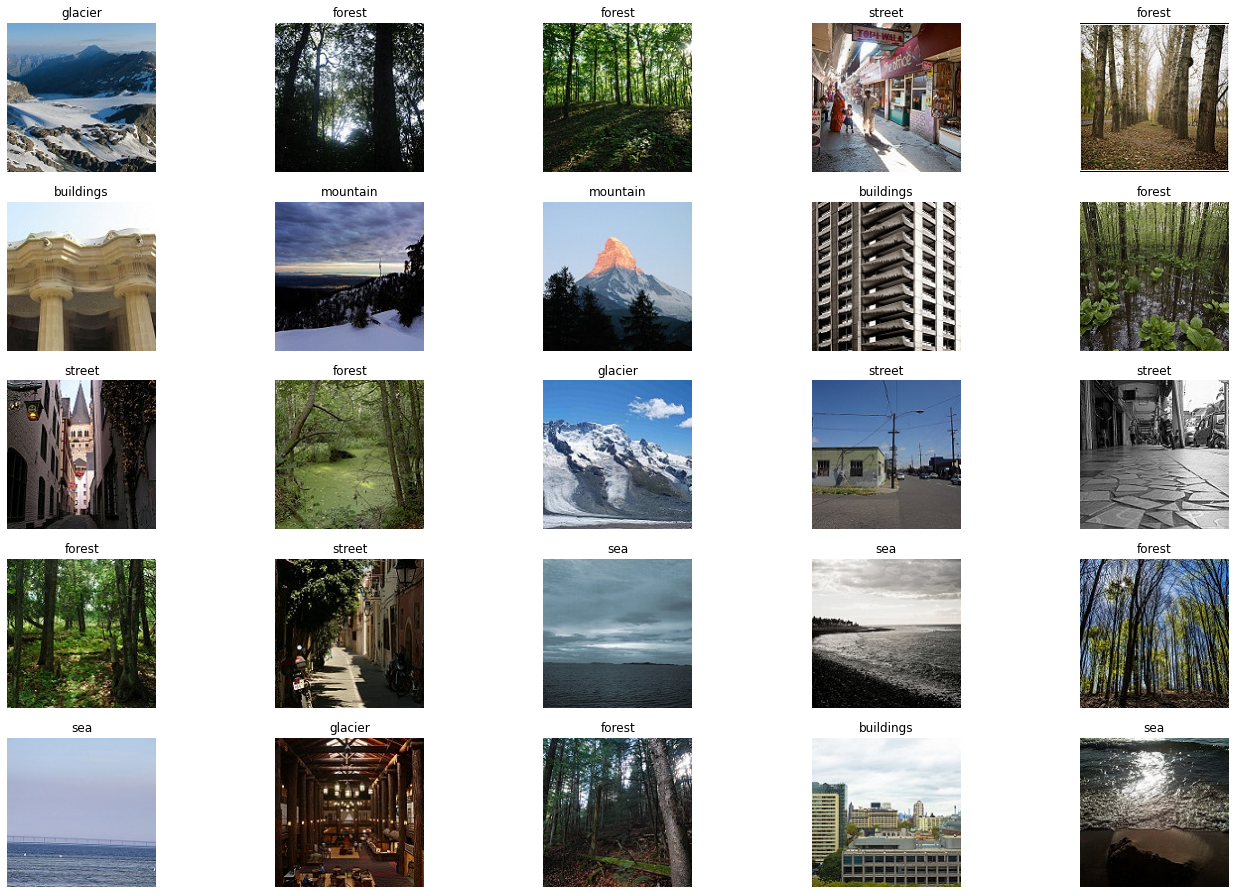

In [ ]:
random_plot(X,y)    
# random_plot(X_test,y_test)    

# Particionamento dos dados

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
     X, y, stratify=y, test_size=0.33, random_state=42)

# Pré-processamento

In [ ]:
# Ajustando o y
hot = OneHotEncoder()
y_train = hot.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val = hot.transform(y_val.reshape(-1, 1)).toarray()
y_test = hot.transform(y_test.reshape(-1, 1)).toarray()

# Ajustando o X entre 0 e 1
m = np.max(X_train)
X_train = X_train/m
X_val = X_val/m
X_test = X_test/m

In [ ]:
from tensorflow.python.keras.layers import Input, Dense, Activation, Dropout, Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras import optimizers

# Avaliação do modelo


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.metrics import AUC

# Visualizando resultados
def plot_overfitting(historico, metric):
  loss = historico.history[metric]
  val_loss = historico.history['val_'+metric]
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, 'bo', label = f'Training {metric}')
  plt.plot(epochs, val_loss, 'b', label = f'Validation {metric}')
  plt.title(f'Training and validation {metric}')
  plt.legend()
  plt.show()

### Modelo crescente 3cam maxacc=0.52

In [ ]:
n_classes = 6

# Criando um modelo sequencial
rede_simples = Sequential()
rede_simples.add(Flatten()) 
n_pixels =  X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
rede_simples.add(Dense(6*3,  input_dim = n_pixels))
# Função de ativacao 
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(6*9))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(6*21))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(n_classes))
rede_simples.add(Activation('softmax'))

rede_simples.compile(loss = 'categorical_crossentropy',
                     optimizer = 'Adam', 
                     metrics=['accuracy'])

#### 6. Treinamento
historico = rede_simples.fit(X_train, 
                             y_train, 
                             epochs = 15,
                             batch_size=64,
                             verbose = 1,
                             validation_data = (X_val, y_val))

Epoch 1/15
147/147 [==============================] - 3s 19ms/step - loss: 1.7390 - accuracy: 0.3376 - val_loss: 1.4813 - val_accuracy: 0.3556
Epoch 2/15
147/147 [==============================] - 2s 11ms/step - loss: 1.3768 - accuracy: 0.4536 - val_loss: 1.2878 - val_accuracy: 0.4873
Epoch 3/15
147/147 [==============================] - 2s 11ms/step - loss: 1.3117 - accuracy: 0.4856 - val_loss: 1.3012 - val_accuracy: 0.4851
Epoch 4/15
147/147 [==============================] - 2s 13ms/step - loss: 1.2788 - accuracy: 0.4982 - val_loss: 1.2461 - val_accuracy: 0.5106
Epoch 5/15
147/147 [==============================] - 2s 13ms/step - loss: 1.2688 - accuracy: 0.5013 - val_loss: 1.3518 - val_accuracy: 0.4754
Epoch 6/15
147/147 [==============================] - 2s 13ms/step - loss: 1.1947 - accuracy: 0.5350 - val_loss: 1.2361 - val_accuracy: 0.5212
Epoch 7/15
147/147 [==============================] - 2s 13ms/step - loss: 1.1724 - accuracy: 0.5474 - val_loss: 1.2949 - val_accuracy: 0.4976

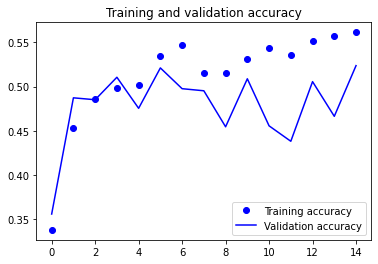

In [ ]:
# plot_overfitting(historico,'loss')
# plot_overfitting(historico,'auc')
plot_overfitting(historico,'accuracy')

### Modelo crescente 2 cam [incapaz de aprender]

In [ ]:
n_classes = 6

# Criando um modelo sequencial
rede_simples = Sequential()
rede_simples.add(Flatten()) 
n_pixels =  X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
rede_simples.add(Dense(6*3,  input_dim = n_pixels))
# Função de ativacao 
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(6*9))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(n_classes))
rede_simples.add(Activation('softmax'))

rede_simples.compile(loss = 'categorical_crossentropy',
                     optimizer = 'Adam', 
                     metrics=['accuracy'])

#### 6. Treinamento
historico = rede_simples.fit(X_train, 
                             y_train, 
                             epochs = 15,
                             batch_size=64,
                             verbose = 1,
                             validation_data = (X_val, y_val))

Epoch 1/15
147/147 [==============================] - 5s 29ms/step - loss: 2.2118 - accuracy: 0.1640 - val_loss: 1.7914 - val_accuracy: 0.1790
Epoch 2/15
147/147 [==============================] - 2s 11ms/step - loss: 1.7913 - accuracy: 0.1790 - val_loss: 1.7910 - val_accuracy: 0.1790
Epoch 3/15
147/147 [==============================] - 2s 11ms/step - loss: 1.7911 - accuracy: 0.1790 - val_loss: 1.7909 - val_accuracy: 0.1790
Epoch 4/15
147/147 [==============================] - 2s 11ms/step - loss: 1.7910 - accuracy: 0.1790 - val_loss: 1.7908 - val_accuracy: 0.1790
Epoch 5/15
147/147 [==============================] - 2s 10ms/step - loss: 1.7909 - accuracy: 0.1790 - val_loss: 1.7908 - val_accuracy: 0.1790
Epoch 6/15
147/147 [==============================] - 2s 12ms/step - loss: 1.7909 - accuracy: 0.1790 - val_loss: 1.7908 - val_accuracy: 0.1790
Epoch 7/15
147/147 [==============================] - 2s 14ms/step - loss: 1.7909 - accuracy: 0.1790 - val_loss: 1.7908 - val_accuracy: 0.1790

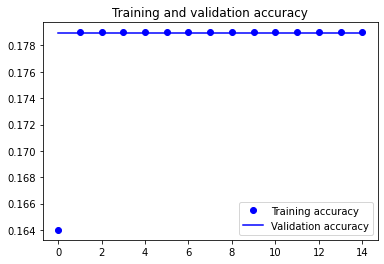

In [ ]:
# plot_overfitting(historico,'loss')
# plot_overfitting(historico,'auc')
plot_overfitting(historico,'accuracy')

### Modelo Decrescente com 4 cam maxacc = 0.46
Não houve melhoria, ao contrário, ouve redução da acurácia em validação. 

In [ ]:
n_classes = 6

# Criando um modelo sequencial
rede_simples = Sequential()
rede_simples.add(Flatten()) 
n_pixels =  X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
rede_simples.add(Dense(6*3,  input_dim = n_pixels))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(6*9))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(6*21))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(6*32))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(n_classes))
rede_simples.add(Activation('softmax'))

rede_simples.compile(loss = 'categorical_crossentropy',
                     optimizer = 'Adam', 
                     metrics=['accuracy'])

#### 6. Treinamento
historico = rede_simples.fit(X_train, 
                             y_train, 
                             epochs = 40,
                             batch_size=64,
                             verbose = 1,
                             validation_data = (X_val, y_val))

Epoch 1/40
147/147 [==============================] - 4s 22ms/step - loss: 1.7390 - accuracy: 0.2750 - val_loss: 1.5443 - val_accuracy: 0.3292
Epoch 2/40
147/147 [==============================] - 2s 14ms/step - loss: 1.4525 - accuracy: 0.4147 - val_loss: 1.4038 - val_accuracy: 0.4419
Epoch 3/40
147/147 [==============================] - 2s 12ms/step - loss: 1.4607 - accuracy: 0.4113 - val_loss: 1.4559 - val_accuracy: 0.3685
Epoch 4/40
147/147 [==============================] - 2s 12ms/step - loss: 1.3907 - accuracy: 0.4367 - val_loss: 1.4968 - val_accuracy: 0.3927
Epoch 5/40
147/147 [==============================] - 2s 11ms/step - loss: 1.3635 - accuracy: 0.4497 - val_loss: 1.4868 - val_accuracy: 0.4175
Epoch 6/40
147/147 [==============================] - 2s 12ms/step - loss: 1.3296 - accuracy: 0.4683 - val_loss: 1.3672 - val_accuracy: 0.4497
Epoch 7/40
147/147 [==============================] - 2s 12ms/step - loss: 1.3052 - accuracy: 0.4780 - val_loss: 1.3269 - val_accuracy: 0.4503

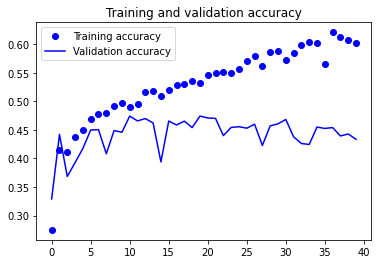

In [ ]:
# plot_overfitting(historico,'loss')
# plot_overfitting(historico,'auc')
plot_overfitting(historico,'accuracy')

### Modelo decrescente 3camdas, neuronios reduzidos
REduz a aprendizagem 0.37

In [ ]:
n_classes = 6

# Criando um modelo sequencial
rede_simples = Sequential()
rede_simples.add(Flatten()) 
n_pixels =  X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
rede_simples.add(Dense(4*3,  input_dim = n_pixels))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(4*9))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(4*21))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(n_classes))
rede_simples.add(Activation('softmax'))

rede_simples.compile(loss = 'categorical_crossentropy',
                     optimizer = 'Adam', 
                     metrics=['accuracy'])

#### 6. Treinamento
historico = rede_simples.fit(X_train, 
                             y_train, 
                             epochs = 30,
                             batch_size=64,
                             verbose = 1,
                             validation_data = (X_val, y_val))

Epoch 1/40
147/147 [==============================] - 5s 28ms/step - loss: 1.7799 - accuracy: 0.2525 - val_loss: 1.7204 - val_accuracy: 0.2297
Epoch 2/40
147/147 [==============================] - 2s 11ms/step - loss: 1.5732 - accuracy: 0.3013 - val_loss: 1.6056 - val_accuracy: 0.2766
Epoch 3/40
147/147 [==============================] - 2s 11ms/step - loss: 1.5217 - accuracy: 0.3148 - val_loss: 1.5189 - val_accuracy: 0.3098
Epoch 4/40
147/147 [==============================] - 2s 11ms/step - loss: 1.4926 - accuracy: 0.3340 - val_loss: 1.4985 - val_accuracy: 0.3465
Epoch 5/40
147/147 [==============================] - 2s 11ms/step - loss: 1.4745 - accuracy: 0.3410 - val_loss: 1.4922 - val_accuracy: 0.3061
Epoch 6/40
147/147 [==============================] - 2s 11ms/step - loss: 1.4464 - accuracy: 0.3638 - val_loss: 1.4894 - val_accuracy: 0.3674
Epoch 7/40
147/147 [==============================] - 2s 11ms/step - loss: 1.4193 - accuracy: 0.3759 - val_loss: 1.4905 - val_accuracy: 0.3409

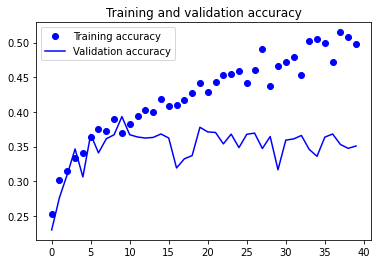

In [ ]:
# plot_overfitting(historico,'loss')
# plot_overfitting(historico,'auc')
plot_overfitting(historico,'accuracy')

# Modelo Crescente redução das menores camadas
Foi possível descobrir que apenas a mairo camada de 21 importava para a maior acurácia.
Porém ficou um modleo bastante instável.
- Será que duas desta dimensão vão resolver melhor o problema?



In [ ]:
n_classes = 6

# Criando um modelo sequencial
rede_simples = Sequential()
rede_simples.add(Flatten()) 
n_pixels =  X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
rede_simples.add(Dense(6*21,  input_dim = n_pixels))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(n_classes))
rede_simples.add(Activation('softmax'))

rede_simples.compile(loss = 'categorical_crossentropy',
                     optimizer = 'Adam', 
                     metrics=['accuracy'])

#### 6. Treinamento
historico = rede_simples.fit(X_train, 
                             y_train, 
                             epochs = 30,
                             batch_size=64,
                             verbose = 1,
                             validation_data = (X_val, y_val))

Epoch 1/30
147/147 [==============================] - 4s 19ms/step - loss: 7.5133 - accuracy: 0.3517 - val_loss: 1.8879 - val_accuracy: 0.4734
Epoch 2/30
147/147 [==============================] - 2s 12ms/step - loss: 2.4451 - accuracy: 0.4260 - val_loss: 3.2732 - val_accuracy: 0.2617
Epoch 3/30
147/147 [==============================] - 2s 12ms/step - loss: 1.8145 - accuracy: 0.4717 - val_loss: 1.5926 - val_accuracy: 0.5045
Epoch 4/30
147/147 [==============================] - 2s 11ms/step - loss: 1.6881 - accuracy: 0.4752 - val_loss: 1.7827 - val_accuracy: 0.4618
Epoch 5/30
147/147 [==============================] - 2s 12ms/step - loss: 1.6262 - accuracy: 0.4848 - val_loss: 1.7816 - val_accuracy: 0.4307
Epoch 6/30
147/147 [==============================] - 2s 12ms/step - loss: 1.4538 - accuracy: 0.5128 - val_loss: 1.8837 - val_accuracy: 0.3638
Epoch 7/30
147/147 [==============================] - 2s 12ms/step - loss: 1.3081 - accuracy: 0.5390 - val_loss: 2.0341 - val_accuracy: 0.3778

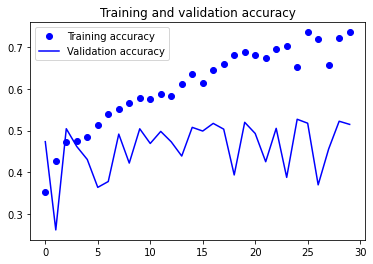

In [ ]:
# plot_overfitting(historico,'loss')
# plot_overfitting(historico,'auc')
plot_overfitting(historico,'accuracy')

## MODELO 126 neuronios 2 camadas mais estável, em .55
NEste modelo conseguimos capturar a ordem adequada de quantidade de neuronios para captura do problema. a acc s emanteve mais estável ao longo dos epochs.
* tentar leve incremento com dropout?


In [ ]:
n_classes = 6

# Criando um modelo sequencial
rede_simples = Sequential()
rede_simples.add(Flatten()) 
n_pixels =  X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
rede_simples.add(Dense(6*21,  input_dim = n_pixels))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(6*21))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(n_classes))
rede_simples.add(Activation('softmax'))

rede_simples.compile(loss = 'categorical_crossentropy',
                     optimizer = 'Adam', 
                     metrics=['accuracy'])

#### 6. Treinamento
historico = rede_simples.fit(X_train, 
                             y_train, 
                             epochs = 30,
                             batch_size=64,
                             verbose = 1,
                             validation_data = (X_val, y_val))

Epoch 1/30
147/147 [==============================] - 3s 18ms/step - loss: 4.4141 - accuracy: 0.3456 - val_loss: 1.5067 - val_accuracy: 0.4741
Epoch 2/30
147/147 [==============================] - 2s 12ms/step - loss: 1.6723 - accuracy: 0.4414 - val_loss: 1.5708 - val_accuracy: 0.4214
Epoch 3/30
147/147 [==============================] - 2s 12ms/step - loss: 1.3280 - accuracy: 0.5055 - val_loss: 1.3111 - val_accuracy: 0.4953
Epoch 4/30
147/147 [==============================] - 2s 12ms/step - loss: 1.2865 - accuracy: 0.5218 - val_loss: 1.2789 - val_accuracy: 0.5127
Epoch 5/30
147/147 [==============================] - 2s 12ms/step - loss: 1.2664 - accuracy: 0.5359 - val_loss: 1.3719 - val_accuracy: 0.4793
Epoch 6/30
147/147 [==============================] - 2s 12ms/step - loss: 1.2273 - accuracy: 0.5475 - val_loss: 1.2871 - val_accuracy: 0.5285
Epoch 7/30
147/147 [==============================] - 2s 12ms/step - loss: 1.1722 - accuracy: 0.5657 - val_loss: 1.3449 - val_accuracy: 0.4864

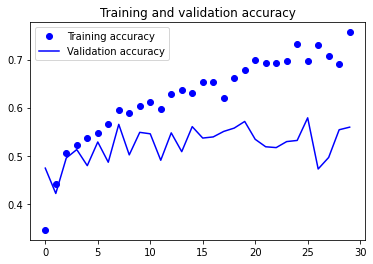

In [ ]:
# plot_overfitting(historico,'loss')
# plot_overfitting(historico,'auc')
plot_overfitting(historico,'accuracy')

## MODELO 126 neuronios 3 camadas mais estável, em .55
Se aumentarmos as camadas, ganharemos ainda mais? Resposta, parece que não.


In [ ]:
n_classes = 6

# Criando um modelo sequencial
rede_simples = Sequential()
rede_simples.add(Flatten()) 
n_pixels =  X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
rede_simples.add(Dense(5*21,  input_dim = n_pixels))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(6*21))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(8*21))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(n_classes))
rede_simples.add(Activation('softmax'))

rede_simples.compile(loss = 'categorical_crossentropy',
                     optimizer = 'Adam', 
                     metrics=['accuracy'])

#### 6. Treinamento
historico = rede_simples.fit(X_train, 
                             y_train, 
                             epochs = 30,
                             batch_size=64,
                             verbose = 1,
                             validation_data = (X_val, y_val))

Epoch 1/30
147/147 [==============================] - 4s 20ms/step - loss: 2.4317 - accuracy: 0.3550 - val_loss: 1.3390 - val_accuracy: 0.4808
Epoch 2/30
147/147 [==============================] - 2s 12ms/step - loss: 1.3399 - accuracy: 0.4812 - val_loss: 1.2946 - val_accuracy: 0.5162
Epoch 3/30
147/147 [==============================] - 2s 12ms/step - loss: 1.2625 - accuracy: 0.5169 - val_loss: 1.2518 - val_accuracy: 0.5205
Epoch 4/30
147/147 [==============================] - 2s 12ms/step - loss: 1.2100 - accuracy: 0.5374 - val_loss: 1.1637 - val_accuracy: 0.5535
Epoch 5/30
147/147 [==============================] - 2s 12ms/step - loss: 1.1859 - accuracy: 0.5478 - val_loss: 1.3371 - val_accuracy: 0.4553
Epoch 6/30
147/147 [==============================] - 2s 12ms/step - loss: 1.1759 - accuracy: 0.5466 - val_loss: 1.1957 - val_accuracy: 0.5559
Epoch 7/30
147/147 [==============================] - 2s 12ms/step - loss: 1.1389 - accuracy: 0.5637 - val_loss: 1.1791 - val_accuracy: 0.5399

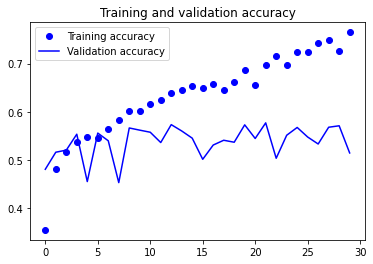

In [ ]:
# plot_overfitting(historico,'loss')
# plot_overfitting(historico,'auc')
plot_overfitting(historico,'accuracy')

## MODELO 147 neuronios 3 camadas com dropout 
O dropout não estava sendo útil. um [artigo do Jason Brownlee](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/)
Sugeria aumentar o learning rate e deixar uma taxa de decaimento. infelizmente não conseguimos encontrar melhorias. Então deixamos com a configuração original.

Porém paree que lentamente o modelo está aprendendo.
Vamos deixar ele rodar com um early stop por mais tempo e verifica ros resultados.

In [ ]:
n_classes = 6

# Criando um modelo sequencial
rede_simples = Sequential()
rede_simples.add(Flatten()) 
n_pixels =  X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
rede_simples.add(Dense(7*21,  input_dim = n_pixels))
rede_simples.add(Dropout(0.1))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(7*21))
rede_simples.add(Dropout(0.1))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(7*21))
rede_simples.add(Dropout(0.1))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(n_classes))
rede_simples.add(Activation('softmax'))

# Sem alcançar melhorias, mantivemos os parâmetros iniciais
opt= optimizers.adam_v2.Adam(learning_rate=0.001, decay=0)
rede_simples.compile(loss = 'categorical_crossentropy',
                     optimizer = opt, 
                     metrics=['accuracy'])

#### 6. Treinamento
historico = rede_simples.fit(X_train, 
                             y_train, 
                             epochs = 30,
                             batch_size=64,
                             verbose = 1,
                             validation_data = (X_val, y_val))

Epoch 1/30
147/147 [==============================] - 5s 32ms/step - loss: 2.5935 - accuracy: 0.2994 - val_loss: 1.4800 - val_accuracy: 0.4184
Epoch 2/30
147/147 [==============================] - 2s 12ms/step - loss: 1.5116 - accuracy: 0.3706 - val_loss: 1.3817 - val_accuracy: 0.4534
Epoch 3/30
147/147 [==============================] - 2s 11ms/step - loss: 1.4240 - accuracy: 0.4123 - val_loss: 1.4169 - val_accuracy: 0.4566
Epoch 4/30
147/147 [==============================] - 2s 12ms/step - loss: 1.4776 - accuracy: 0.3549 - val_loss: 1.3833 - val_accuracy: 0.3964
Epoch 5/30
147/147 [==============================] - 2s 11ms/step - loss: 1.4186 - accuracy: 0.3998 - val_loss: 1.4880 - val_accuracy: 0.3819
Epoch 6/30
147/147 [==============================] - 2s 12ms/step - loss: 1.4090 - accuracy: 0.4176 - val_loss: 1.3518 - val_accuracy: 0.4644
Epoch 7/30
147/147 [==============================] - 2s 12ms/step - loss: 1.3998 - accuracy: 0.4233 - val_loss: 1.3499 - val_accuracy: 0.4573

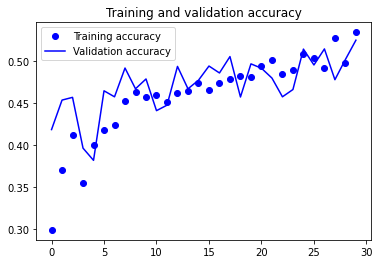

In [ ]:
# plot_overfitting(historico,'loss')
# plot_overfitting(historico,'auc')
plot_overfitting(historico,'accuracy')

### Modelo com dropout e Early Stop
De fato o ganho permanecia até o epoch 30, depois voltavamos ao problema anterior.

In [ ]:
n_classes = 6

# Criando um modelo sequencial
rede_simples = Sequential()
rede_simples.add(Flatten()) 
n_pixels =  X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
rede_simples.add(Dense(7*21,  input_dim = n_pixels))
rede_simples.add(Dropout(0.1))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(7*21))
rede_simples.add(Dropout(0.1))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(7*21))
rede_simples.add(Dropout(0.1))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(n_classes))
rede_simples.add(Activation('softmax'))

# Sem alcançar melhorias, mantivemos os parâmetros iniciais
opt= optimizers.adam_v2.Adam(learning_rate=0.001, decay=0)
rede_simples.compile(loss = 'categorical_crossentropy',
                     optimizer = opt, 
                     metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0.001, 
                   patience = 15, verbose = 1, 
                   mode = 'auto')

#### 6. Treinamento
historico = rede_simples.fit(X_train, 
                             y_train, 
                             epochs = 300,
                             batch_size=64,
                             verbose = 1,
                             validation_data = (X_val, y_val),
                             callbacks = [es])

Epoch 1/300
147/147 [==============================] - 3s 18ms/step - loss: 2.4126 - accuracy: 0.2960 - val_loss: 1.5663 - val_accuracy: 0.3260
Epoch 2/300
147/147 [==============================] - 2s 12ms/step - loss: 1.5993 - accuracy: 0.3130 - val_loss: 1.5724 - val_accuracy: 0.3128
Epoch 3/300
147/147 [==============================] - 2s 12ms/step - loss: 1.5681 - accuracy: 0.3349 - val_loss: 1.4501 - val_accuracy: 0.3953
Epoch 4/300
147/147 [==============================] - 2s 12ms/step - loss: 1.5503 - accuracy: 0.3421 - val_loss: 1.5388 - val_accuracy: 0.3195
Epoch 5/300
147/147 [==============================] - 2s 12ms/step - loss: 1.5431 - accuracy: 0.3425 - val_loss: 1.4776 - val_accuracy: 0.3711
Epoch 6/300
147/147 [==============================] - 2s 12ms/step - loss: 1.4931 - accuracy: 0.3770 - val_loss: 1.4596 - val_accuracy: 0.3767
Epoch 7/300
147/147 [==============================] - 2s 12ms/step - loss: 1.4808 - accuracy: 0.3907 - val_loss: 1.5262 - val_accuracy:

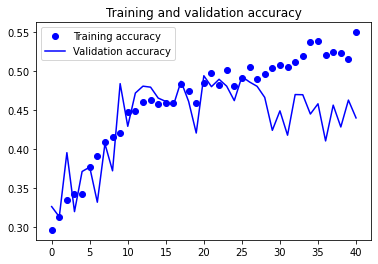

In [ ]:
# plot_overfitting(historico,'loss')
# plot_overfitting(historico,'auc')
plot_overfitting(historico,'accuracy')

# Melhor modelo:
Vamos parar a aprendizagem na epoch 12, por parcimônia e para evitar ovverfitting

In [ ]:
n_classes = 6

# Criando um modelo sequencial
rede_simples = Sequential()
rede_simples.add(Flatten()) 
n_pixels =  X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
rede_simples.add(Dense(5*21,  input_dim = n_pixels))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(6*21))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(8*21))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(n_classes))
rede_simples.add(Activation('softmax'))

rede_simples.compile(loss = 'categorical_crossentropy',
                     optimizer = 'Adam', 
                     metrics=['accuracy'])

#### 6. Treinamento
historico = rede_simples.fit(X_train, 
                             y_train, 
                             epochs = 12,
                             batch_size=64,
                             verbose = 1,
                             validation_data = (X_val, y_val))

Epoch 1/12
147/147 [==============================] - 4s 21ms/step - loss: 3.1206 - accuracy: 0.3609 - val_loss: 1.5129 - val_accuracy: 0.4441
Epoch 2/12
147/147 [==============================] - 2s 14ms/step - loss: 1.3945 - accuracy: 0.4752 - val_loss: 1.3253 - val_accuracy: 0.4791
Epoch 3/12
147/147 [==============================] - 2s 14ms/step - loss: 1.2595 - accuracy: 0.5208 - val_loss: 1.4129 - val_accuracy: 0.4601
Epoch 4/12
147/147 [==============================] - 2s 14ms/step - loss: 1.2520 - accuracy: 0.5247 - val_loss: 1.2308 - val_accuracy: 0.5397
Epoch 5/12
147/147 [==============================] - 2s 14ms/step - loss: 1.2010 - accuracy: 0.5447 - val_loss: 1.2937 - val_accuracy: 0.5166
Epoch 6/12
147/147 [==============================] - 2s 13ms/step - loss: 1.1882 - accuracy: 0.5491 - val_loss: 1.3654 - val_accuracy: 0.4778
Epoch 7/12
147/147 [==============================] - 2s 14ms/step - loss: 1.1357 - accuracy: 0.5658 - val_loss: 1.1819 - val_accuracy: 0.5499

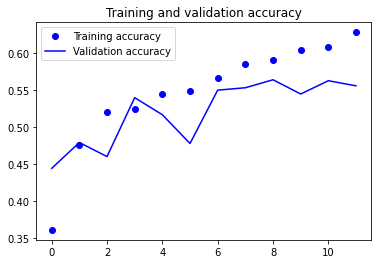

In [ ]:
# plot_overfitting(historico,'loss')
# plot_overfitting(historico,'auc')
plot_overfitting(historico,'accuracy')

# avaliando pela base de teste
Desempenho Semelhante, o que indica que realmente conseguimos para o modelo antes do overfitting.

A classe 4 é dificel de ser identificada, sendo confundida com diversas classes, 1,3 e 5.

In [ ]:
# Desempenho em teste
pred_simples = rede_simples.predict(X_test)
print('acc_score: ',accuracy_score(y_test.argmax(1), pred_simples.argmax(1)))
print(confusion_matrix(y_test.argmax(1), pred_simples.argmax(1)))

acc_score:  0.551
[[129  16  36 127  63  66]
 [ 21 324  12  29  31  57]
 [ 10   4 351 124  52  12]
 [ 14   5  65 413  26   2]
 [ 33  23 129 148 154  23]
 [ 49  28  53  55  34 282]]


# Desempenho para resolução reduzida (mesmo treinamento de modelo)
* Pela validação era esperado desempenho igual para o modelo
* Apresenta também tendência de overfittign ao longo do tempo.
* Pelo teste o desempenho foi o esperado, semelhante à validação
* **Desempenho resolução de 150 foi igual ao da resolução de 100**
* O modelo ficou mais rápido para treinar.

In [ ]:
res_x = res_y = 100

train_path = "/content/datas/dataset/seg_train/**/*.jpg"
X, y = import_imgs_as_array(train_path, 5, res_x,res_y)
print(X.shape)

test_path = "/content/datas/dataset/seg_test/**/*.jpg"
X_test, y_test = import_imgs_as_array(test_path, 6, res_x,res_y)
print(X_test.shape)

(14034, 100, 100, 3)
(3000, 100, 100, 3)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
     X, y, stratify=y, test_size=0.33, random_state=42)

In [ ]:
# Ajustando o y
hot = OneHotEncoder()
y_train = hot.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val = hot.transform(y_val.reshape(-1, 1)).toarray()
y_test = hot.transform(y_test.reshape(-1, 1)).toarray()

# Ajustando o X entre 0 e 1
m = np.max(X_train)
X_train = X_train/m
X_val = X_val/m
X_test = X_test/m

In [ ]:
n_classes = 6

# Criando um modelo sequencial
rede_simples = Sequential()
rede_simples.add(Flatten()) 
n_pixels =  X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
rede_simples.add(Dense(5*21,  input_dim = n_pixels))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(6*21))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(8*21))
rede_simples.add(Activation('relu'))
rede_simples.add(Dense(n_classes))
rede_simples.add(Activation('softmax'))

rede_simples.compile(loss = 'categorical_crossentropy',
                     optimizer = 'Adam', 
                     metrics=['accuracy'])

#### 6. Treinamento
historico = rede_simples.fit(X_train, 
                             y_train, 
                             epochs = 12,
                             batch_size=64,
                             verbose = 1,
                             validation_data = (X_val, y_val))

Epoch 1/12
147/147 [==============================] - 3s 13ms/step - loss: 1.6595 - accuracy: 0.4054 - val_loss: 1.3428 - val_accuracy: 0.4773
Epoch 2/12
147/147 [==============================] - 1s 8ms/step - loss: 1.3097 - accuracy: 0.4955 - val_loss: 1.2471 - val_accuracy: 0.5220
Epoch 3/12
147/147 [==============================] - 1s 7ms/step - loss: 1.2457 - accuracy: 0.5177 - val_loss: 1.2775 - val_accuracy: 0.5106
Epoch 4/12
147/147 [==============================] - 1s 7ms/step - loss: 1.1751 - accuracy: 0.5516 - val_loss: 1.1709 - val_accuracy: 0.5546
Epoch 5/12
147/147 [==============================] - 1s 7ms/step - loss: 1.1751 - accuracy: 0.5453 - val_loss: 1.1877 - val_accuracy: 0.5570
Epoch 6/12
147/147 [==============================] - 1s 7ms/step - loss: 1.1348 - accuracy: 0.5666 - val_loss: 1.1840 - val_accuracy: 0.5451
Epoch 7/12
147/147 [==============================] - 1s 7ms/step - loss: 1.1092 - accuracy: 0.5780 - val_loss: 1.1185 - val_accuracy: 0.5771
Epoch

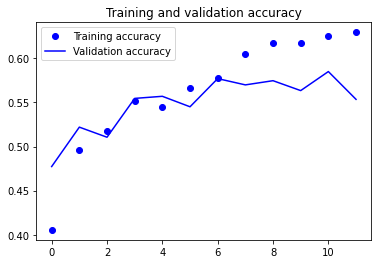

In [ ]:
# plot_overfitting(historico,'loss')
# plot_overfitting(historico,'auc')
plot_overfitting(historico,'accuracy')

In [ ]:
# Desempenho em teste
pred_simples = rede_simples.predict(X_test)
print('acc_score: ',accuracy_score(y_test.argmax(1), pred_simples.argmax(1)))
print(confusion_matrix(y_test.argmax(1), pred_simples.argmax(1)))

acc_score:  0.545
[[127  11  35  98  14 152]
 [ 15 302  11  12   8 126]
 [ 31   5 316 119  44  38]
 [ 23   7  37 396  24  38]
 [ 53  25 116 137  93  86]
 [ 36  11  30  18   5 401]]


IndentationError: ignored

# Bônus:
A base já está balanceada.

In [ ]:
# Pergunta bonus!
np.unique(y, return_counts=True)

(array(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
       dtype='<U9'), array([2191, 2271, 2404, 2512, 2274, 2382]))